### Data setup

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

imputedDataset = pd.read_stata("/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta")

In [2]:
import statsmodels.api as sm

imputedDataset = imputedDataset.rename({'selfReportMI' : 'mi', 
                                        'selfReportStroke' : 'stroke', 
                                        'tot_chol' : 'totChol',
                                        'meanDBP' : 'meanDbp',
                                        'meanSBP' : 'meanSbp',
                                        'age' : 'baseAge'}, axis='columns')

imputedDataset['anyDeath'] = imputedDataset.ucod >= 1
imputedDataset['nonCVDeath'] = imputedDataset.ucod == 3
imputedDataset['cvDeath'] = imputedDataset.ucod.isin([1,2])


imputedDataset = imputedDataset.loc[imputedDataset.year < 2011] # we dont' have mortality data after this time
#imputedDataset.monthsToDeath.loc[imputedDataset.anyDeath==0] = np.nan

sf1 = sm.duration.SurvfuncRight(imputedDataset.monthsToDeath, imputedDataset.nonCVDeath)
sf1.summary().head()

,Surv prob,Surv prob SE,num at risk,num events
Time,,,,
5.397605e-79,0.999646,0.000102,33902,12.0
1.000000e+00,0.999410,0.000132,33889,8.0
2.000000e+00,0.998584,0.000204,33874,28.0
3.000000e+00,0.998082,0.000238,33834,17.0
4.000000e+00,0.997521,0.000270,33805,19.0


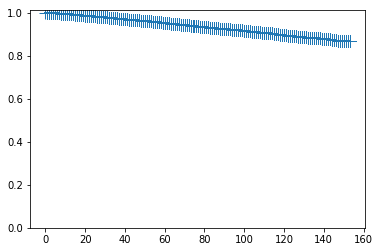

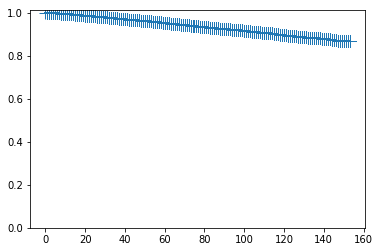

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

sf1.plot()

### Build Mortality Model

In [4]:
imputedDataset['squareBaseAge'] = imputedDataset['baseAge']**2
coxModel = sm.PHReg.from_formula("monthsToDeath ~  baseAge + squareBaseAge + a1c + bmi + gender + hdl + ldl + mi + stroke + totChol + trig + meanSbp + meanDbp + raceEthnicity + smokingStatus", status="nonCVDeath", data=imputedDataset)
results = coxModel.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: PHReg
========================================================================
Model:                      PH Reg              Sample size:       33902
Dependent variable:         monthsToDeath       Num. events:       2280 
Ties:                       Breslow                                     
------------------------------------------------------------------------
                    log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------------------
raceEthnicity[T.2] -0.0538    0.1240 0.9477 -0.4336 0.6646 0.7432 1.2083
raceEthnicity[T.3]  0.1369    0.0631 1.1468  2.1718 0.0299 1.0134 1.2976
raceEthnicity[T.4]  0.2793    0.0745 1.3222  3.7488 0.0002 1.1426 1.5301
raceEthnicity[T.5] -0.0855    0.1482 0.9181 -0.5766 0.5642 0.6866 1.2276
smokingStatus[T.1]  0.3145    0.0495 1.3696  6.3578 0.0000 1.2430 1.5090
smokingStatus[T.2]  0.9355    0.0614 2.5486 15.2421 0.0000 2.2597 2.8744
baseAge             0.0324    0.0110 1.0329  2.9440 0.0032 1.0109 1.0554
squareBaseAge       0.0004    0.0001 1.0004  4.4783 0.0000 1.0002 1.0006
a1c                 0.1322    0.0166 1.1414  7.9510 0.0000 1.1048 1.1792
bmi                -0.0160    0.0042 0.9841 -3.8295 0.0001 0.9761 0.9922
gender             -0.2745    0.0478 0.7599 -5.7449 0.0000 0.6920 0.8346
hdl                -0.0022    0.0020 0.9978 -1.1006 0.2711 0.9938 1.0018
ldl                -0.0001    0.0019 0.9999 -0.0723 0.9424 0.9961 1.0037
mi                  0.5090    0.0594 1.6635  8.5629 0.0000 1.4806 1.8691
stroke              0.3759    0.0659 1.4564  5.7077 0.0000 1.2800 1.6570
totChol            -0.0006    0.0018 0.9994 -0.3439 0.7309 0.9958 1.0030
trig                0.0001    0.0002 1.0001  0.5609 0.5749 0.9997 1.0005
meanSbp             0.0043    0.0010 1.0043  4.3552 0.0000 1.0024 1.0062
meanDbp            -0.0027    0.0013 0.9973 -2.0029 0.0452 0.9947 0.9999
========================================================================
Confidence intervals are for the hazard ratios
"""

### Figure out how to get baseline cumulative hazard function

In [5]:
# get the baseline cumulative hazard at one year.
tuples = coxModel.baseline_cumulative_hazard(results.params)
rawOneYearCumHazard = tuples[0][1][12]

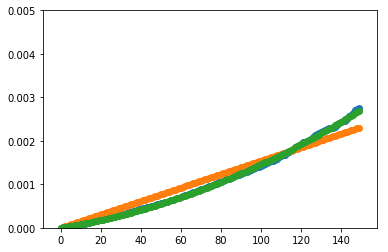

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# ok...here is a trick — the cumulative hazard curve is non linear
# applyign the 12 month cumulative hazard (repatedly, as per our plan) is going to lead to underestimation on the long-term
# to start, let's try and fit a simple linear model to the cmulative hazard curve 
# then plug that in as a baseline hazard
time = tuples[0][0]
timeYears = time/ 12
cumSurv = tuples[0][2]
cumHaz = tuples[0][1]


plt.scatter(time, cumHaz )
plt.ylim(0.000, 0.005)

model = sm.OLS(cumHaz , timeYears)
cumHazardLinearResult = model.fit()

plt.scatter(time, cumHazardLinearResult.params[0] * timeYears )

model = sm.OLS(cumHaz , np.column_stack((timeYears, timeYears**2)))
cumHazardQuadResult = model.fit()

quadOutcome = cumHazardQuadResult.params[0] * timeYears + cumHazardQuadResult.params[1] * timeYears**2
plt.scatter(time, quadOutcome)

plt.show()

### So, the quadratic (green line on top of the blue line) fits very well...export to json and use for the model

In [7]:
import sys
import os
sys.path.append(os.path.abspath("../mcm/"))
from mcm.cox_regression_model import CoxRegressionModel


coxModelExport = CoxRegressionModel(dict(zip(results.model.exog_names, results.params)),
                              dict(zip(results.model.exog_names, results.standard_errors)), 
                              cumHazardQuadResult.params[0] , cumHazardQuadResult.params[1] )

coxModelExport.write_json(os.path.abspath("../mcm/mcm/data/nhanesMortalityModelSpec.json"))

### In the calibration, we find that we're-over-predicting mortality in the simluation. 

Possible explanations:
<ul>
    <li> Bad model fit in NHANES</li>
    <li> Misimplementaiton of cumulative hazard logic</li>
    <li> Misimplementaiton of the one year aggregation of the cumulative hazard</li>
    <li> Coding Error </li>
</ul>

## first, let's check that the model is well-calibrated against itself...

In [8]:
cumHazardPredicted = coxModel.predict(results.params, pred_type='cumhaz').predicted_values
betaOutput = coxModel.predict(results.params, pred_type='lhr').predicted_values

In [10]:
imputedDataset['monthsToDeath'] = imputedDataset['monthsToDeath'].astype(int)
imputedDataset['monthsToDeath'].loc[imputedDataset['monthsToDeath'] >=149] = 149
imputedDataset['cumHazardAt2011'] = cumHaz[imputedDataset.monthsToDeath]
imputedDataset['estimatedCumHazardAt2011'] = cumHazardQuadResult.params[0] * imputedDataset.monthsToDeath/12 + cumHazardQuadResult.params[1] * (imputedDataset.monthsToDeath/12)**2

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
imputedDataset['cumHazardPredicted'] = cumHazardPredicted
imputedDataset['betaOutput'] = betaOutput
imputedDataset['calcCumHazard'] = imputedDataset.cumHazardAt2011 * np.exp(imputedDataset.betaOutput)
imputedDataset['calcCumHazardUsingEstimation'] = imputedDataset.estimatedCumHazardAt2011 * np.exp(imputedDataset.betaOutput)
imputedDataset['delta'] = imputedDataset.cumHazardPredicted - imputedDataset.calcCumHazard

In [12]:
imputedDataset.groupby('anyDeath')['delta'].describe() 

,count,mean,std,min,25%,50%,75%,max
anyDeath,,,,,,,,
False,30262.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
True,3640.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### So, we've checked that our calculattion of the cumulative hazard lines up with what the model predicts...

                anyDeath  calcCumHazard  calcCumHazardUsingEstimation  \
ageDecile                                                               
(18.999, 23.0]  0.008031       0.004003                      0.003992   
(23.0, 29.0]    0.008277       0.005665                      0.005645   
(29.0, 35.0]    0.010328       0.007801                      0.007770   
(35.0, 41.0]    0.019808       0.012019                      0.011974   
(41.0, 47.0]    0.030247       0.018312                      0.018247   
(47.0, 54.0]    0.051435       0.029459                      0.029315   
(54.0, 61.0]    0.087304       0.050501                      0.050269   
(61.0, 69.0]    0.138024       0.093777                      0.093350   
(69.0, 77.0]    0.236428       0.165261                      0.164633   
(77.0, 85.0]    0.506944       0.287200                      0.285515   

                  baseAge  
ageDecile                  
(18.999, 23.0]  20.570466  
(23.0, 29.0]    26.498965  
(29.0, 35.0

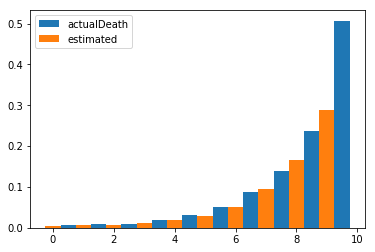

In [13]:
imputedDataset['ageDecile'] = pd.qcut(imputedDataset.baseAge, 10)
output = imputedDataset.groupby('ageDecile')[['anyDeath', 'calcCumHazard', 'calcCumHazardUsingEstimation', 'baseAge']].mean()
print(output)
plt.bar(output.index.codes+0.5, output.anyDeath, width=0.5, label="actualDeath")
plt.bar(output.index.codes, output.calcCumHazard, width=0.5, label="estimated")
plt.legend()

### So, we do not have a fundamental failure of model calibration...it looks pretty good in the sample it was derived from. Also, we tested our quadratic estimate on the baseline hazard and it looks like it also performs well.

However there was one interesting potential lesson here — if the times to event are a little bit off it can lead to very different conclusions. 

### One other thing to check that came up when validating the overall simulation against NHANES...is there under-prediciton in teh oldest old under long follow-up? Let's specifically check

In [14]:
earlyCrossSectionOfNonImmigrants = pd.read_stata("/Users/burke/Documents/research/bpCog/nhanes/earlyCrossSectionOfNonImmigrants.dta")
earlyCrossSectionOfNonImmigrants['ageDecile'] = pd.qcut(earlyCrossSectionOfNonImmigrants.age, 10)
earlyCrossSectionOfNonImmigrants['squareBaseAge'] = earlyCrossSectionOfNonImmigrants.age**2

earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.rename({'selfReportMI' : 'mi', 
                                        'selfReportStroke' : 'stroke', 
                                        'tot_chol' : 'totChol',
                                        'meanDBP' : 'meanDbp',
                                        'meanSBP' : 'meanSbp',
                                        'age' : 'baseAge'}, axis='columns')

earlyCrossSectionOfNonImmigrants = pd.concat([earlyCrossSectionOfNonImmigrants, pd.get_dummies(earlyCrossSectionOfNonImmigrants.raceEthnicity, prefix='raceEthnicity')], axis=1)
earlyCrossSectionOfNonImmigrants = pd.concat([earlyCrossSectionOfNonImmigrants, pd.get_dummies(earlyCrossSectionOfNonImmigrants.smokingStatus, prefix='smokingStatus')], axis=1)

In [15]:
variablesForModel = earlyCrossSectionOfNonImmigrants[['raceEthnicity_2', 'raceEthnicity_3', 'raceEthnicity_4', 'raceEthnicity_5', 'smokingStatus_1', 'smokingStatus_2','baseAge', 'squareBaseAge', 'a1c','bmi','gender', 'hdl', 'ldl','mi','stroke', 'totChol', 'trig', 'meanSbp', 'meanDbp']]

cumHazardPredicted = coxModel.predict(results.params, exog=variablesForModel, endog=earlyCrossSectionOfNonImmigrants.monthsToDeath,
                                      pred_type='cumhaz').predicted_values
earlyCrossSectionOfNonImmigrants['cumHazardPredicted'] = cumHazardPredicted

                diedBy2011  cumHazardPredicted
ageDecile                                     
(20.999, 25.0]    0.024291            0.008427
(25.0, 30.0]      0.023904            0.010037
(30.0, 36.0]      0.014109            0.014037
(36.0, 40.0]      0.069378            0.019267
(40.0, 45.0]      0.021239            0.026139
(45.0, 49.0]      0.046154            0.037151
(49.0, 54.0]      0.065891            0.053316
(54.0, 61.0]      0.099567            0.083952
(61.0, 72.0]      0.208421            0.163467
(72.0, 85.0]      0.631915            0.327812


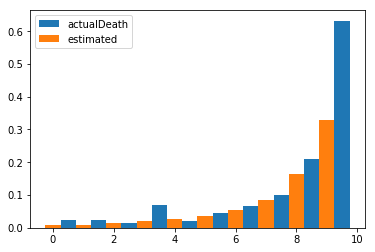

In [16]:
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['diedBy2011', 'cumHazardPredicted']].mean()
print(output)
plt.bar(output.index.codes+0.5, output.diedBy2011, width=0.5, label="actualDeath")
plt.bar(output.index.codes, output.cumHazardPredicted, width=0.5, label="estimated")
plt.legend()

### Doesn't look like it — using the NHANES based dataset (earlyImmigrants) for comparison of long term mortality and then running the predictions using the model estiamted here, we're getting very similar predictions to what we saw in the whle sample...

### So, the next step is to run the model on these same data and comapre...first, we'll run the model with our implementtation of the cox model. THen we'll run the markov-ed version

In [17]:
from mcm.gender import NHANESGender
from mcm.person import Person
from mcm.outcome import Outcome
from mcm.race_ethnicity import NHANESRaceEthnicity
from mcm.smoking_status import SmokingStatus
from mcm.cohort_risk_model_repository import CohortRiskModelRepository
from mcm.outcome_model_repository import OutcomeModelRepository

In [ ]:
import os 

cohortModel = OutcomeModelRepository()
riskModel = CohortRiskModelRepository()

def calcMortalityRunningFullModel(x):
        temp =  Person(
            age=x.baseAge,
            gender=NHANESGender(int(x.gender)),
            raceEthnicity=NHANESRaceEthnicity(int(x.raceEthnicity)),
            sbp=x.meanSbp,
            dbp=x.meanDbp,
            a1c=x.a1c,
            hdl=x.hdl,
            ldl=x.ldl,
            trig=x.trig,
            totChol=x.totChol,
            bmi=x.bmi,
            smokingStatus=SmokingStatus(int(x.smokingStatus)),
            dfIndex=x.index,
            diedBy2011=x.diedBy2011)
        
        for year in range(1,11):
            if not temp.is_dead():
                temp.advance_year(riskModel, cohortModel)
        return temp.is_dead()


earlyCrossSectionOfNonImmigrants['estMortalityFromModel'] = earlyCrossSectionOfNonImmigrants.apply(calcMortalityRunningFullModel, axis=1)

In [ ]:
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['diedBy2011', 'cumHazardPredicted',  'estMortalityFromModel']].mean()
print(output)
plt.bar(output.index.codes+1, output.diedBy2011, width=0.20, label="actualDeath")
plt.bar(output.index.codes+1.2, output.cumHazardPredicted, width=0.20, label="direct model estimate")
plt.bar(output.index.codes+1.6, output.estMortalityFromModel, width=0.20, label="full code")

plt.legend()

### Ok...this is telling the story, i think...
1. there is a small problem witht eh green bars — rthey should be exactly the same as the orange bars or extremely close.
 to figure that out, we can just esetimat ethe linear predictors and hazard functions for both and compare
2. the bigger problem si that the red bars are over-estimating risk. its conceivable that whatefger the problem in #1 is is being amplified
, but its more likely thtat there is something wrong about aggregating over time...

In [24]:
def calcLinearPredictorUsingModel(x):
    temp =  Person(
            age=x.baseAge,
            gender=NHANESGender(int(x.gender)),
            raceEthnicity=NHANESRaceEthnicity(int(x.raceEthnicity)),
            sbp=x.meanSbp,
            dbp=x.meanDbp,
            a1c=x.a1c,
            hdl=x.hdl,
            ldl=x.ldl,
            trig=x.trig,
            totChol=x.totChol,
            bmi=x.bmi,
            smokingStatus=SmokingStatus(int(x.smokingStatus)),
            dfIndex=x.index,
            diedBy2011=x.diedBy2011)
    return statsModel.linear_predictor(temp)

def calcCumHazardUsingModel(x):
    temp =  Person(
            age=x.baseAge,
            gender=NHANESGender(int(x.gender)),
            raceEthnicity=NHANESRaceEthnicity(int(x.raceEthnicity)),
            sbp=x.meanSbp,
            dbp=x.meanDbp,
            a1c=x.a1c,
            hdl=x.hdl,
            ldl=x.ldl,
            trig=x.trig,
            totChol=x.totChol,
            bmi=x.bmi,
            smokingStatus=SmokingStatus(int(x.smokingStatus)),
            dfIndex=x.index,
            diedBy2011=x.diedBy2011)
    return statsModel.get_cumulative_hazard_for_interval(0, x.monthsToDeath/12)

cohortModel = OutcomeModelRepository()
riskModel = CohortRiskModelRepository()

earlyCrossSectionOfNonImmigrants['estLinearPredictorFromOurCode'] = earlyCrossSectionOfNonImmigrants.apply(calcLinearPredictorUsingModel, axis=1)
earlyCrossSectionOfNonImmigrants['estCumHazardFromOurCode'] = earlyCrossSectionOfNonImmigrants.apply(calcCumHazardUsingModel, axis=1)


In [27]:
variablesForModel = earlyCrossSectionOfNonImmigrants[['raceEthnicity_2', 'raceEthnicity_3', 'raceEthnicity_4', 'raceEthnicity_5', 'smokingStatus_1', 'smokingStatus_2','baseAge', 'squareBaseAge', 'a1c','bmi','gender', 'hdl', 'ldl','mi','stroke', 'totChol', 'trig', 'meanSbp', 'meanDbp']]

linearPredictorPredicted = coxModel.predict(results.params, exog=variablesForModel, endog=earlyCrossSectionOfNonImmigrants.monthsToDeath,
                                      pred_type='lhr').predicted_values
earlyCrossSectionOfNonImmigrants['linearPredictorFromCox'] = linearPredictorPredicted
earlyCrossSectionOfNonImmigrants['baselineHazardFromCox'] = cumHaz[earlyCrossSectionOfNonImmigrants.monthsToDeath.astype(int)]

                linearPredictorFromCox  estLinearPredictorFromOurCode
ageDecile                                                            
(20.999, 26.0]                1.003385                       1.000636
(26.0, 31.0]                  1.157677                       1.155450
(31.0, 36.0]                  1.342369                       1.333863
(36.0, 40.0]                  1.671952                       1.663334
(40.0, 45.0]                  1.841432                       1.833784
(45.0, 49.0]                  2.232966                       2.224690
(49.0, 54.0]                  2.563518                       2.540487
(54.0, 60.0]                  2.920201                       2.892655
(60.0, 72.0]                  3.715388                       3.657640
(72.0, 85.0]                  5.092387                       4.946215


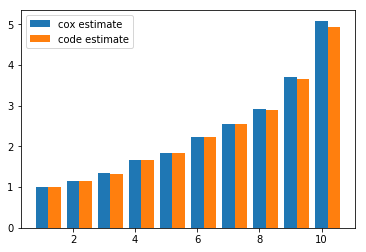

In [28]:
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['linearPredictorFromCox', 'estLinearPredictorFromOurCode']].mean()
print(output)
plt.bar(output.index.codes+1, output.linearPredictorFromCox, width=0.40, label="cox estimate")
plt.bar(output.index.codes+1.4, output.estLinearPredictorFromOurCode, width=0.40, label="code estimate")

plt.legend()

                estCumHazardFromOurCode  baselineHazardFromCox
ageDecile                                                     
(20.999, 26.0]                 0.005613               0.005576
(26.0, 31.0]                   0.005532               0.005495
(31.0, 36.0]                   0.005569               0.005529
(36.0, 40.0]                   0.005489               0.005454
(40.0, 45.0]                   0.005521               0.005488
(45.0, 49.0]                   0.005417               0.005392
(49.0, 54.0]                   0.005377               0.005344
(54.0, 60.0]                   0.005385               0.005359
(60.0, 72.0]                   0.004932               0.004897
(72.0, 85.0]                   0.003521               0.003509


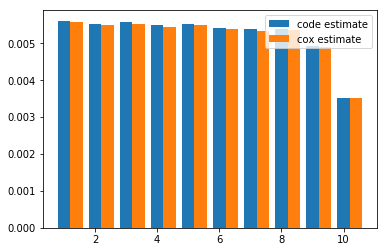

In [30]:
output = earlyCrossSectionOfNonImmigrants.groupby('ageDecile')[['estCumHazardFromOurCode', 'baselineHazardFromCox']].mean()
print(output)
plt.bar(output.index.codes+1, output.estCumHazardFromOurCode, width=0.40, label="code estimate")
plt.bar(output.index.codes+1.4, output.baselineHazardFromCox, width=0.40, label="cox estimate")

plt.legend()